PDHG algorithm

In [1]:
# Package import
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN , gradient
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data
import time


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
from modopt.math.metrics import ssim
from scipy.stats import norm

import numpy as np
import matplotlib.pyplot as plt

import nibabel as nib
import h5py

## Import data and add noise

### Cartesian Fourier operator and noise

In [3]:
u0 = get_sample_data('2d-mri')
u0_mat = u0.data*(1+0j)

In [4]:
(n,m) = u0_mat.shape
x = np.linspace(0,m,m,endpoint=False)/m-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

mask = convert_locations_to_mask(kspace_loc,u0_mat.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0_mat.shape,implementation='cpu')

# Adding noise
s = 0.1*np.mean(u0_mat)
# Computing y with non-cartesian Fourier transform
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0_mat.shape,implementation='cpu')
y = (1+0j)*fourier_op.op(u0_mat)+s*np.random.randn(2*n*m).view(np.complex128)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


### Creating a random cartesian mask or projecting a radial mask on cartesian grid

In [5]:
x = np.linspace( -0.5, 0.5, n, endpoint = False )
p = np.array([norm.pdf(u,loc=0,scale=0.2) for u in x])
p /= np.sum(p)
y_sampled = np.random.choice( x, size=int(0.6*n), p=p, replace=False)

#Subsampling: From pysap radial mask 
cartesian_p = np.zeros(n**2+1)
cartesian_p[-1] = 7e-7
for yi in y_sampled:
    j=int((yi+0.5)*n)
    cartesian_p[j*n:(j+1)*n] = np.ones((n,))
pysap.Image(data=np.reshape(cartesian_p[:-1],(n,n))).show()

In [6]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data
radial_p = np.zeros((n*n+1,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
radial_p[n*ind1+ind2]=1
radial_p[-1] = 7e-7

### Operators

In [7]:
#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=4,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

In [8]:
#ifft on noised data = base result
uk = fourier_op.adj_op(radial_p[:-1]*y)
print(ssim(uk,u0_mat))
pysap.Image(data = np.real(uk)).show()
pysap.Image(data = np.arctan(np.imag(uk)/np.real(uk))).show()

0.7538292255587153


## Reconstruction

In [9]:
# Specific files import
from LowerLevel.prox import prox_G,prox_F1_dual,prox_F2_dual
from LowerLevel.pdhg import pdhg
from LowerLevel.cost_utils import f1,f2,g

In [10]:
param = {"epsilon":1e-3,"gamma":1e-10}

In [11]:
print(g(u0_mat,param["epsilon"]),
      f2(linear_op.op(u0_mat),radial_p[-1],param["gamma"]),
      f1(u0_mat,radial_p[:-1],y,fourier_op))

1.9073479506915348e-09 7.747514396905899e-08 1.8613871750297372e-09


In [13]:
# -- Solving --
# myconst = {"sigma":0.4,"tau":1.1}
uk,norms,energy,ssims = pdhg(y , radial_p ,
                             fourier_op = fourier_op,
                             linear_op = linear_op,
                             param = param,
                             ground_truth=u0_mat,
                             maxit=200,
                             compute_energy = True)

alpha:7e-07
Sigma: 0.022360679774997897 
Tau: 22.360679774997898
10  iterations:
Cost: 1.5493341918465298e-06 
Norm: 1.1207805946626679 

20  iterations:
Cost: 5.943098401911322e-08 
Norm: 0.07644406698615946 

30  iterations:
Cost: 5.5435423658269464e-08 
Norm: 0.03435197586725154 

40  iterations:
Cost: 5.407119081554088e-08 
Norm: 0.023870417678689245 

50  iterations:
Cost: 5.300164660145007e-08 
Norm: 0.018112446102707926 

60  iterations:
Cost: 5.213607212710446e-08 
Norm: 0.014006850934490514 

70  iterations:
Cost: 5.141496014707502e-08 
Norm: 0.01110831792495195 

80  iterations:
Cost: 5.081014472069403e-08 
Norm: 0.00902868686039252 

90  iterations:
Cost: 5.0297848088277896e-08 
Norm: 0.007369913887816515 

100  iterations:
Cost: 4.9857056903803324e-08 
Norm: 0.006195916865856667 

110  iterations:
Cost: 4.9478070847590484e-08 
Norm: 0.005185377418228195 

120  iterations:
Cost: 4.913687388820315e-08 
Norm: 0.004383019894691342 

130  iterations:
Cost: 4.884904886611418e-08 

In [14]:
#Showing
print(ssim(u0_mat,uk))
pysap.Image(data = np.abs(uk)).show()

0.9235031459045142


In [15]:
print(g(uk,param["epsilon"]),f2(linear_op.op(uk),radial_p[-1],param["gamma"]),f1(uk,radial_p[:-1],y,fourier_op))

1.8209297824355612e-09 3.9512557123095605e-08 6.249521428662905e-09


In [16]:
pysap.Image(data = np.abs(np.abs(uk)-u0_mat)).show()

In [17]:
pysap.Image(data = np.arctan(np.imag(uk)/np.real(uk))).show()

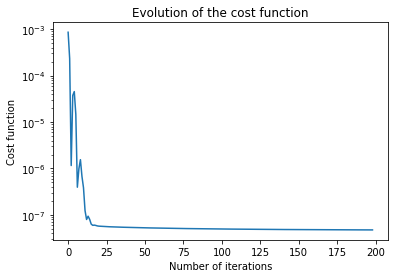

In [18]:
plt.plot(energy[1:])
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("Cost function")
plt.title("Evolution of the cost function")
plt.yscale("log")
#plt.savefig("Comparisons/haar/pdhg/Complex/energy.png")
plt.show()

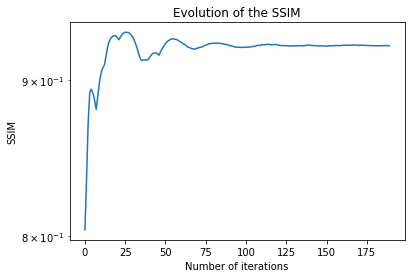

In [19]:
plt.plot(ssims[10:])
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("SSIM")
plt.title("Evolution of the SSIM")
plt.yscale("log")
#plt.savefig("Comparisons/haar/pdhg/Complex/metrics.png")
plt.show()

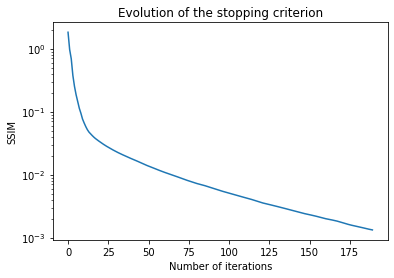

In [20]:
plt.plot(norms[10:])
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("SSIM")
plt.title("Evolution of the stopping criterion")
plt.yscale("log")
#plt.savefig("Comparisons/haar/pdhg/Complex/metrics.png")
plt.show()